In [1]:
from numba import njit, prange
import numpy as np
import xarray as xr
import random 
import time
import matplotlib.pyplot as plt
from math import sin

h = 6.62607004e-34
e = 1.6021765e-19
hbar = h / (2 * np.pi)

In [2]:
def RCSJ_JJ(I_dc: np.array, 
           I_rf: np.array,
           f_rf: float, 
           Rj: float, 
           Ic: float,
           C: float,
           sigma: float = 0., 
           n_periods: int = 100, 
           pts_period: int = 1000) -> xr.DataArray:
    
    """
    Function that return the Shapiro map for a current biased Josephson junction with standard RSJ model.

    Args:
        I_dc : np.array, dc current bias points in units of Ic
        I_rf : np.array, ac current bias points in units of Ic
        f_rf: float, frequency of the ac component
        Ic: float, junction critical current
        Rj: float, junction resistance
        C: float, junction capacitance
        sigma: std. dev of gaussian noise in units of Ic
        n_periods: number of periods to cycle in phi(t) evolution
        pts_period: number of points per cycle

    Returns:
        V: xr.DataArray, voltage drop map as a function of I_dc and I_rf 
    """
    
    params = {'f_rf': f_rf, 'Rj': Rj, 'Ic': Ic, 'C': C, 'sigma': sigma, 'n_periods': n_periods, 'pts_period': pts_period}
    
    # Normalized time in units of junction plasma frequency
    t0 = hbar / ( 2 * e * Ic * Rj )
    beta = 2 * e * Ic * Rj**2 * C / hbar
    eta = 2 * np.pi * f_rf * t0

    # Time step for the t vs phi evolution
    dt = 2 * np.pi / ( eta * pts_period )
    n_total = n_periods * pts_period

    @njit
    def CPR(phi):
        """ Return CPR of the junction """

        return sin(phi)

    @njit
    def Dphi(phi,  dphi, t, i_dc, i_rf):
        """ Return derivative of phase """

        return dphi

    @njit
    def DDphi(phi,  dphi, t, i_dc, i_rf):
        """ Return 2nd derivative of phase """

        ddphi = 1/beta * ( i_dc + i_rf * np.sin(eta * t) - CPR(phi) - Dphi(phi,  dphi, t, i_dc, i_rf) )
        
        return ddphi

    @njit
    def RK2(phi, dphi, t, i_dc, i_rf):
        """ 4th order Runge-Kutta method for 3rd order ODE """

        F1 = Dphi(phi, dphi, t, i_dc, i_rf)
        G1 = DDphi(phi, dphi, t, i_dc, i_rf)

        F2 = Dphi(phi + 0.5 * dt * F1, dphi + 0.5 * dt * G1, t + 0.5 * dt, i_dc, i_rf)
        G2 = DDphi(phi + 0.5 * dt * F1, dphi + 0.5 * dt * G1, t + 0.5 * dt, i_dc, i_rf)

        F3 = Dphi(phi + 0.5 * dt * F2, dphi + 0.5 * dt * G2, t + 0.5 * dt, i_dc, i_rf)
        G3 = DDphi(phi + 0.5 * dt * F2, dphi + 0.5 * dt * G2, t + 0.5 * dt, i_dc, i_rf)

        F4 = Dphi(phi + dt * F3, dphi + dt * G3, t + dt, i_dc, i_rf)
        G4 = DDphi(phi + dt * F3, dphi + dt * G3, t + dt, i_dc, i_rf)

        phi_out = phi + dt/6. * (F1 + F4 + 2.*(F2 + F3))
        dphi_out = dphi + dt/6. * (G1 + G4 + 2.*(G2 + G3))
        t_out = t + dt

        return phi_out, dphi_out, t_out

    @njit
    def calculate(i_dc, i_rf, phi0, dphi0):
        """ Calculation function for single i_dc and i_rf points. Phi0 is the initial phase value """
        phi, dphi, t = np.zeros(n_total), np.zeros(n_total), np.zeros(n_total)
        phi[0], dphi[0], t[0] = phi0, dphi0, 0

        for n in range(n_total - 1):
            noise = random.gauss(0, sigma)
            phi[n+1], dphi[n+1], t[n+1] = RK2(phi[n], dphi[n], t[n], i_dc + noise, i_rf)
        
        return (phi[-1]-phi[0])/(t[-1]-t[0]), phi[-1], dphi[-1]


    @njit(parallel=True)
    def loop(V, I_dc, I_rf):
        """ Loop over I_dc and I_rf that return voltage drop map """
        
        for n1 in prange(len(I_rf)):
            V[0, n1], phi0, dphi0 = calculate(I_dc[0], I_rf[n1], phi0 = 0, dphi0 = 0)

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0, dphi0  = calculate(I_dc[n2], I_rf[n1], phi0 = phi0, dphi0 = dphi0)
        return V * Ic * Rj / ( h * f_rf / ( 2 * e ) )

    """ Run the simulation """
    start = time.time()
            
    V = np.zeros((len(I_dc), len(I_rf)))
    V = xr.DataArray(loop(V, I_dc, I_rf), 
                     coords = (('i_dc', I_dc, {'long_name': 'DC current', 'units':'$I_c$'}), 
                               ('i_rf', 20 * np.log10( I_rf ), {'long_name': 'RF current', 'units':'$dB$'})), 
                     attrs = {'long_name': 'Voltage drop', 
                              'units': '$hf/2e$',
                              'params': params})
    

    elapsed_time = time.time() - start
    
    print(f'Simulation took: {elapsed_time:.1f} s')
    
    return V

In [3]:
I_dc = np.linspace(-2,2, 150)
I_rf = np.logspace(-0.5,0.8, 150)
C = np.logspace(-15,-12, 9)
V = [RCSJ_JJ(I_dc, I_rf, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, C=_c, sigma = 0., n_periods=100, pts_period=500) for _c in C]

Simulation took: 8.7 s
Simulation took: 8.2 s
Simulation took: 8.3 s
Simulation took: 8.3 s
Simulation took: 8.5 s
Simulation took: 8.6 s
Simulation took: 8.7 s
Simulation took: 8.7 s
Simulation took: 8.7 s


In [14]:
def get_params(x):
    params = dict(x.attrs['params'])

def capac(x):
    p = dict(x.attrs['params'])
    beta = 2 * e * p['Ic'] * p['Rj']**2 * p['C'] / hbar
    return beta, p['C']

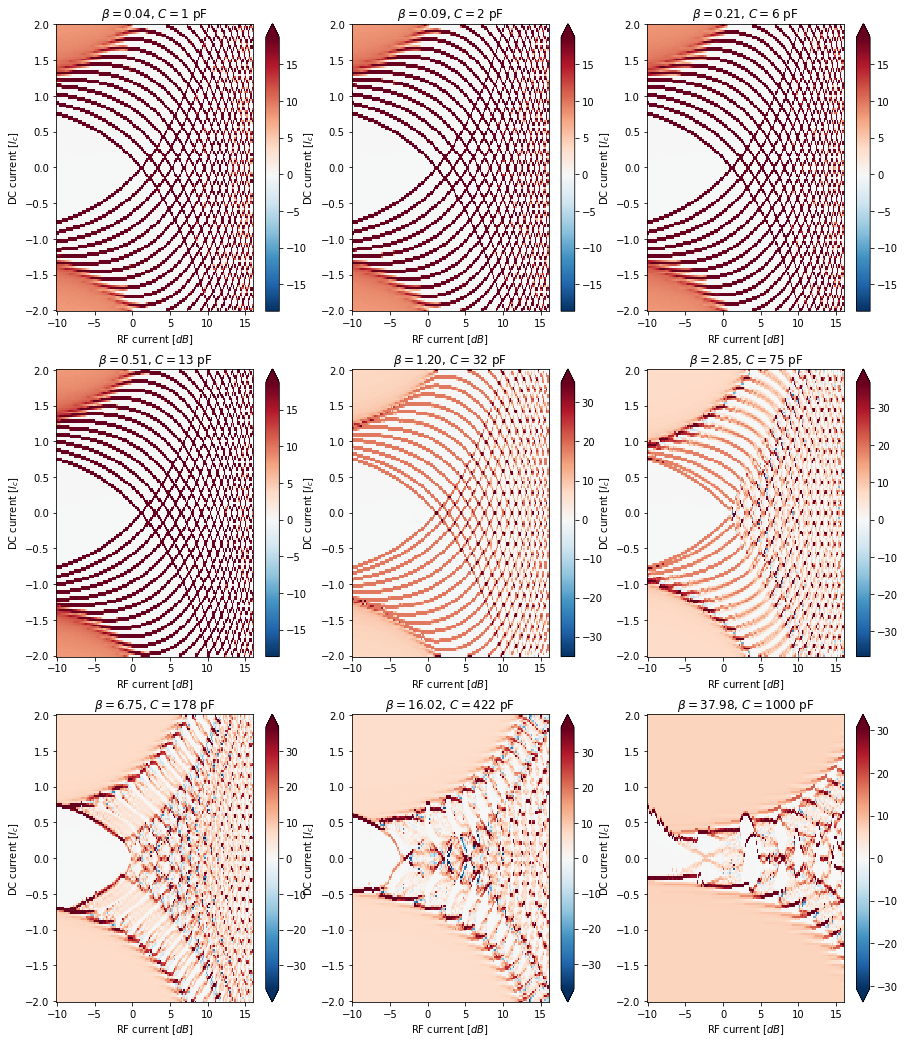

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5*3,6*3))
ax = ax.ravel()
for n in range(len(V)):
    V[n].differentiate('i_dc').plot(ax=ax[n], robust=True)
    _b, _c = capac(V[n])
    ax[n].set(title=f'$\\beta = ${_b:.2f}, $C = ${_c*1e15:.0f} pF')